In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "Ayush@12345",
                             database = "ecommerce")
cur = db.cursor()


# List all unique cities where customers are located.

In [62]:
query = """select distinct(customer_city) from customers """

cur.execute(query)

data = cur.fetchall()
df= pd.DataFrame(data, columns = ['customer_city'])
df.head(10)

,customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul
6,timoteo
7,curitiba
8,belo horizonte
9,montes claros


# Count the number of orders placed in 2017

In [3]:
query = """select count(order_id) from orders where year(order_purchase_timestamp)= 2017 """

cur.execute(query)

data = cur.fetchall()
"Total orders placed in 2017 are ", data [0][0]

('Total orders placed in 2017 are ', 90202)

# Find the total sales per category

In [4]:
query = """ select upper(products.product_category), 
round(sum(payments.payment_value),2) sales 
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by product_category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns= ["Category", "Sales"])
df

,Category,Sales
0,PERFUMERY,2026954.64
1,FURNITURE DECORATION,5720705.57
2,TELEPHONY,1947528.20
3,BED TABLE BATH,6850214.68
4,AUTOMOTIVE,3409177.32
...,...,...
69,CDS MUSIC DVDS,4797.72
70,LA CUISINE,11654.12
71,FASHION CHILDREN'S CLOTHING,3142.68
72,PC GAMER,8697.72


# Calculate the percentage of orders that were paid in installments

In [5]:
query = """ select (sum(case when payment_installments >= 1 then 1 else 0 end))/count(*)*100 from payments
"""

cur.execute(query)

data = cur.fetchall()
" The percentage of orders that were paid in installments is", data [0][0]

(' The percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# Count the number of customers from each state

<function matplotlib.pyplot.show(close=None, block=None)>

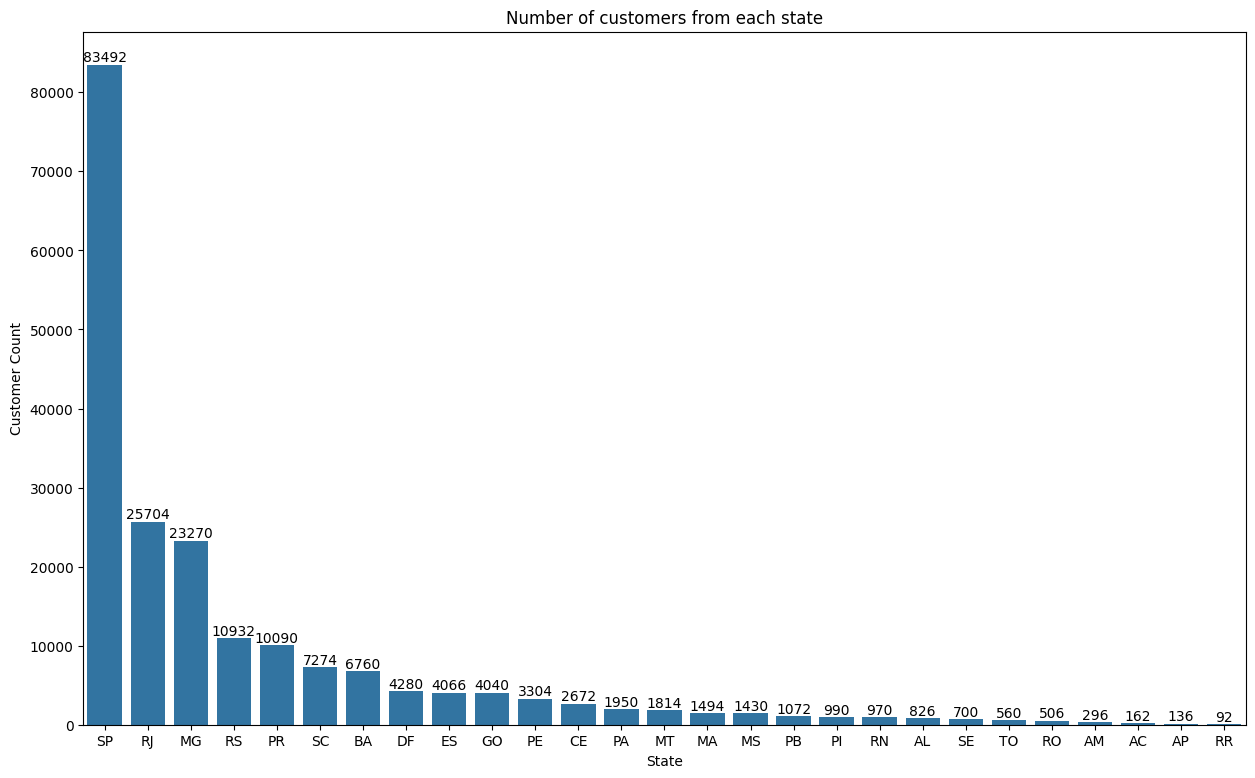

In [6]:
query = """ select customer_state, count(customer_id) from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns= ["State", "Customer Count"])
df = df.sort_values(by = "Customer Count", ascending = False)

plt.figure(figsize=(15,9))
ax = sns.barplot(x=df["State"], y=df["Customer Count"] )
ax.bar_label(ax.containers[0])
plt.title("Number of customers from each state")

plt.show

# Calculate the number of orders per month in 2018

<function matplotlib.pyplot.show(close=None, block=None)>

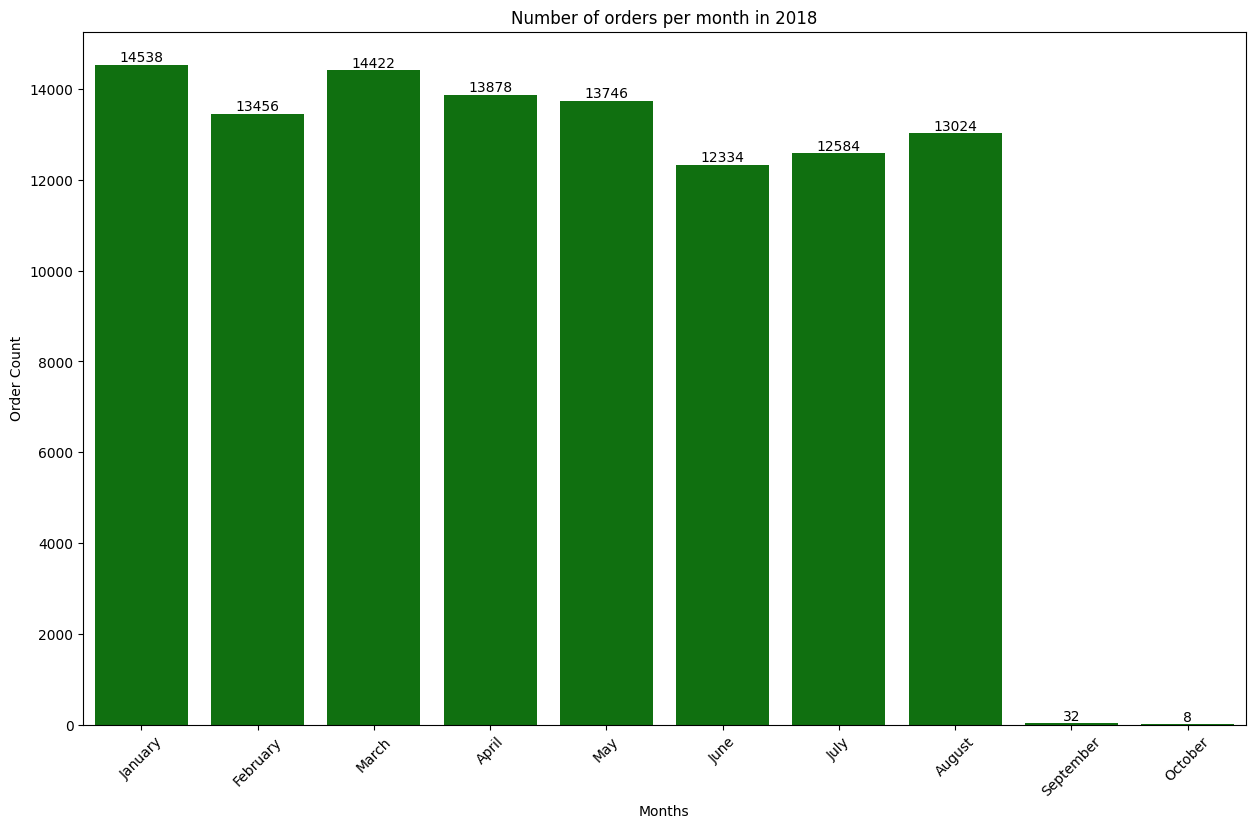

In [7]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp)= 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns= ["Months", "Order Count"])
o = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"] 

plt.figure(figsize=(15,9))
ax = sns.barplot(x = df["Months"], y = df["Order Count"], order = o, color= "green" )
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Number of orders per month in 2018")
plt.show


# Find the average number of products per order, grouped by customer city

In [8]:
query = """ with count_per_order as
(select orders.order_id, orders.customer_id, count(order_items.order_id)as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2)average
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns= ["Cities", " Average Products/Order"])
df.head(10)


,Cities,Average Products/Order
0,treze tilias,2.55
1,indaial,2.23
2,sao jose dos campos,2.28
3,sao paulo,2.31
4,porto alegre,2.35
5,santos,2.32
6,sao francisco do sul,2.47
7,sao vicente,2.18
8,joinville,2.21
9,sao vendelino,2.00


# Calculate the percentage of total revenue contributed by each product category

In [9]:
query = """ select upper(products.product_category), 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales 
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by product_category order by sales desc;
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns= ["Categories", " Percentage distribution"])
df.head(10)


,Categories,Percentage distribution
0,BED TABLE BATH,21.40
1,HEALTH BEAUTY,20.71
2,COMPUTER ACCESSORIES,19.81
3,FURNITURE DECORATION,17.87
4,WATCHES PRESENT,17.86
5,SPORT LEISURE,17.39
6,HOUSEWARES,13.68
7,AUTOMOTIVE,10.65
8,GARDEN TOOLS,10.47
9,COOL STUFF,9.74


# Identify the correlation between product price and the number of times a product has been purchased

In [10]:
query = """ select products.product_category,
count(order_items.product_id),
round(avg(order_items.price), 2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category;
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns= ["Categories", "order_count", "Price"])

arr1 = df["order_count"]
arr2 = df["Price"]

a = np.corrcoef([arr1, arr2])

print("The correlation coefficient between product price and the number of times a product has been purchased is", a[0][1])



The correlation coefficient between product price and the number of times a product has been purchased is -0.10631514167157562


#  Calculate the total revenue generated by each seller, and rank them by revenue

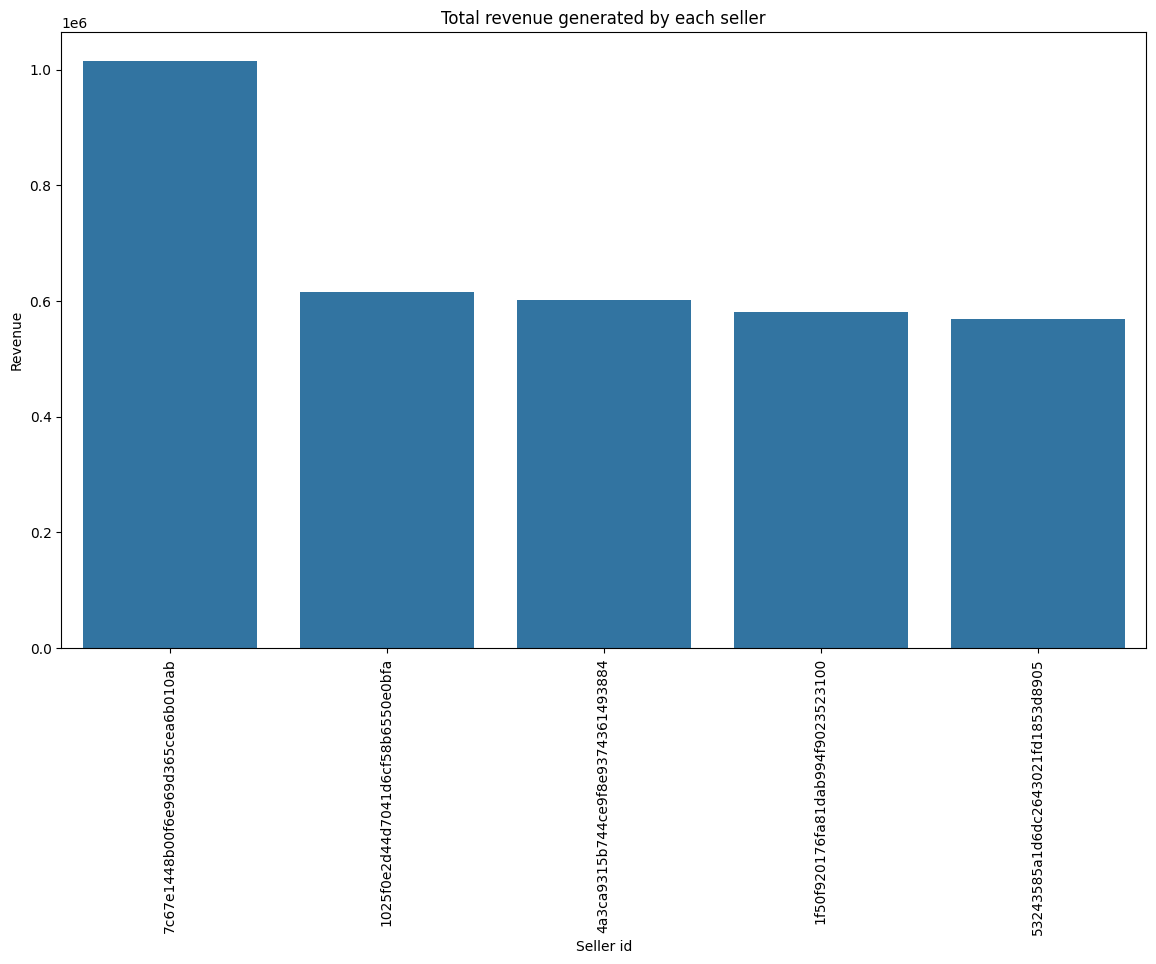

In [14]:
query = """ select *,dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a;
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns= ["Seller id", "Revenue", "Rank"])
df = df.head()
plt.figure(figsize=(14,8))
sns.barplot(x = "Seller id", y = "Revenue", data = df)
plt.xticks(rotation = 90)
plt.title("Total revenue generated by each seller")
plt.show()


# Calculate the moving average of order values for each customer over their order history

In [20]:
query ="""select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a """


cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns= ["Customer Id", "Order history", "Payment", "Mov Avg"])
df.head(20)





,Customer Id,Order history,Payment,Mov Avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
5,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
6,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
7,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
8,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
9,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998


# Calculate the cumulative sales per month for each year

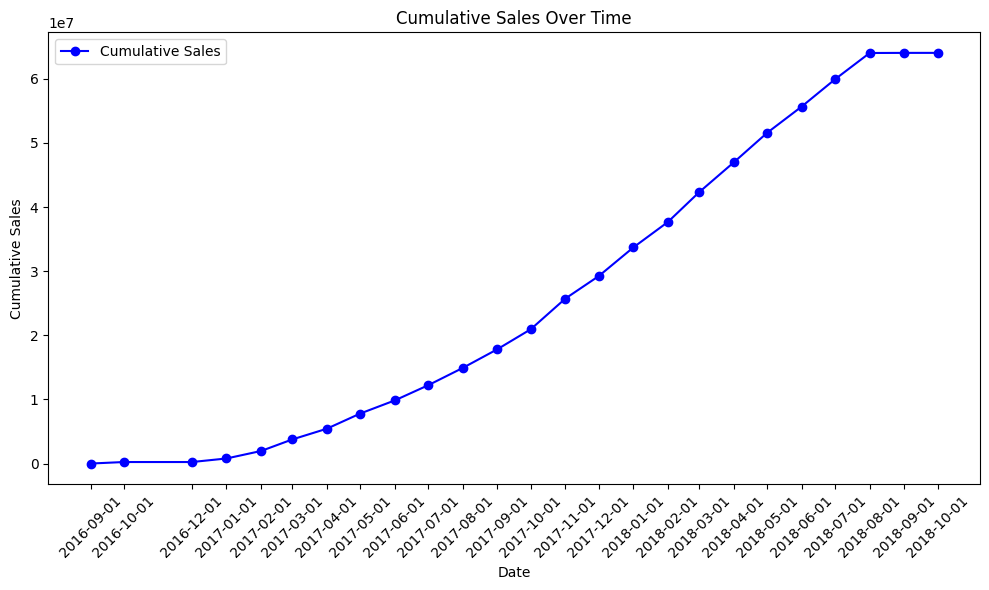

In [36]:
query =""" select years, months, payment, sum(payment)
over(order by years, months) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months)as a;"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns= ["Years", "Months", "Payment", "Cumulative sales"])
df["Date"] = pd.to_datetime(df[["Years", "Months"]].assign(DAY=1))
plt.figure(figsize=(10, 6))
plt.plot(df["Date"], df["Cumulative sales"], marker='o', linestyle='-', color='b', label='Cumulative Sales')
plt.title('Cumulative Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Sales')
plt.xticks(df['Date'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Calculate the year-over-year growth rate of total sales

In [51]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df


,years,yoy % growth
0,2016,NaN
1,2017,12112.703757
2,2018,20.000924


# Identify the top 3 customers who spent the most money in each year

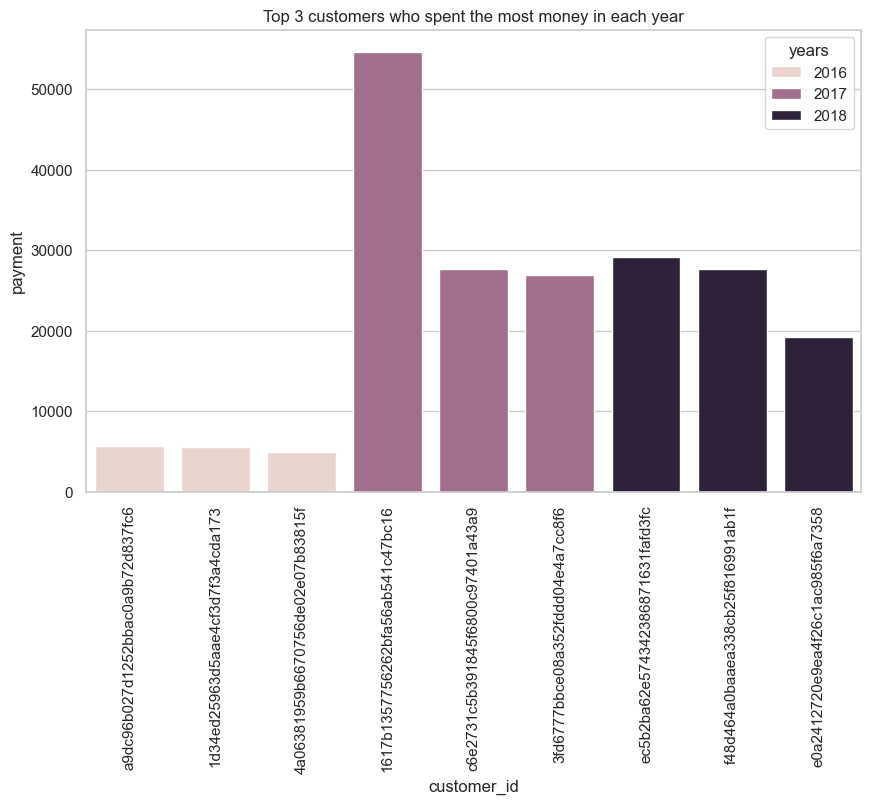

In [55]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","customer_id","payment","rank"])
plt.figure(figsize=(10, 6))
sns.barplot(x = "customer_id", y = "payment", data = df, hue = "years")
plt.title('Top 3 customers who spent the most money in each year')
plt.xticks(rotation = 90)
plt.show()